In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from torchsummary import summary

#vital params

 
model_name="ResNet18_stn2"

dataset_name="caltech101"

#hyperparameters
batch_size=10
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(224,224)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")


Model: ResNet18_stn2 with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketch': 55

In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out
class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
 
        out = self.conv3(out)
        out = self.bn3(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out
class ResNet(nn.Module):
 
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

        self.localization = nn.Sequential(
            nn.Conv2d(3,4,kernel_size=3,stride = 2,padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,10,kernel_size=1),
            nn.BatchNorm2d(10),
            nn.ReLU(True),
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(27040, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        
    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)
        xs = xs.view(-1, 10 * 52 * 52)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

        
 
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
 
        return nn.Sequential(*layers)
 
    def forward(self, x):
        x=self.stn(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
 
        return x

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model
 
 
def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model
 
 
def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model
 
 
def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model
 
 
def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [3]:
model = resnet18()
model.fc=nn.Linear(512,num_classes)
model = model.to(device)

#pretesting model for shape
x=torch.randn(batch_size,3,224,224)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print("model shape ready")
print(summary(model, input_size=(3, 224, 224)))
#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
print("model initialised")

torch.Size([10, 3, 224, 224])
torch.Size([10, 101])
model shape ready
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 112, 112]             112
       BatchNorm2d-2          [-1, 4, 112, 112]               8
              ReLU-3          [-1, 4, 112, 112]               0
            Conv2d-4          [-1, 8, 112, 112]              40
       BatchNorm2d-5          [-1, 8, 112, 112]              16
              ReLU-6          [-1, 8, 112, 112]               0
            Conv2d-7          [-1, 8, 110, 110]             584
       BatchNorm2d-8          [-1, 8, 110, 110]              16
              ReLU-9          [-1, 8, 110, 110]               0
           Conv2d-10          [-1, 4, 110, 110]              36
      BatchNorm2d-11          [-1, 4, 110, 110]               8
             ReLU-12          [-1, 4, 110, 110]               0
           Conv2d-13          [-1

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [4]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [5]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+"/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs//ResNet18_stn220211229101902
grandstore_string
grandstore/caltech101_ResNet18_stn220211229101902.pkl


In [6]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [7]:
TOP_ACCURACY_TRACK = 15
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=400,
                    minepoch=300,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                 
                   )

Running epoch: 1


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8653837.5422 	Validation Loss: 5005.9324

Running epoch: 2


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8396323.8939 	Validation Loss: 5013.1044

Running epoch: 3


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8329914.2444 	Validation Loss: 5010.7826

Running epoch: 4


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8330973.3745 	Validation Loss: 4999.4671

Running epoch: 5


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8343160.4953 	Validation Loss: 4991.5204

Running epoch: 6


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8341907.6247 	Validation Loss: 7082.0034

Running epoch: 7


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8333128.7972 	Validation Loss: 4995.8305

Running epoch: 8


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8340328.1209 	Validation Loss: 4987.1808

Running epoch: 9


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8312198.8941 	Validation Loss: 4988.9198

Running epoch: 10


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8304699.7634 	Validation Loss: 4996.5877

Running epoch: 11


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8300972.3754 	Validation Loss: 4985.2015

Running epoch: 12


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8320142.2170 	Validation Loss: 5001.8425

Running epoch: 13


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8302056.1767 	Validation Loss: 4996.6237

Running epoch: 14


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8309877.2926 	Validation Loss: 4985.5405

Running epoch: 15


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8318594.7297 	Validation Loss: 5014.4486

Running epoch: 16


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8323508.4853 	Validation Loss: 4992.4269

Running epoch: 17


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8332065.4003 	Validation Loss: 4987.8664

Running epoch: 18


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8302799.3747 	Validation Loss: 4991.7303

Running epoch: 19


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8325107.2073 	Validation Loss: 4983.2917

Running epoch: 20


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8319789.6132 	Validation Loss: 4981.5104

Running epoch: 21


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8294524.9713 	Validation Loss: 4986.2050

Running epoch: 22


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8321952.2115 	Validation Loss: 4980.1021

Running epoch: 23


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8308172.1773 	Validation Loss: 4983.2913

Running epoch: 24


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8303102.4265 	Validation Loss: 5284.9077

Running epoch: 25


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8285168.6450 	Validation Loss: 4984.4773

Running epoch: 26


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8316713.0763 	Validation Loss: 4984.8474

Running epoch: 27


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8279851.2658 	Validation Loss: 4981.1137

Running epoch: 28


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8291207.6978 	Validation Loss: 4984.2812

Running epoch: 29


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8308770.5688 	Validation Loss: 4987.2537

Running epoch: 30


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8276313.0074 	Validation Loss: 4991.6860

Running epoch: 31


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8309256.6721 	Validation Loss: 4981.3507

Running epoch: 32


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8312340.6241 	Validation Loss: 4984.1342

Running epoch: 33


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8274744.1034 	Validation Loss: 4985.1239

Running epoch: 34


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8284364.2002 	Validation Loss: 4979.5512

Running epoch: 35


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8256197.0616 	Validation Loss: 4988.9466

Running epoch: 36


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8271187.7684 	Validation Loss: 4985.3466

Running epoch: 37


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8304235.1621 	Validation Loss: 4984.5507

Running epoch: 38


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8304316.8035 	Validation Loss: 4984.1790

Running epoch: 39


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8300711.2083 	Validation Loss: 4982.5311

Running epoch: 40


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8263753.3050 	Validation Loss: 4989.7827

Running epoch: 41


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8283434.8859 	Validation Loss: 4991.7521

Running epoch: 42


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8315274.9558 	Validation Loss: 4981.5638

Running epoch: 43


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8288067.3244 	Validation Loss: 4984.2338

Running epoch: 44


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8301644.9253 	Validation Loss: 4989.1250

Running epoch: 45


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8266294.2132 	Validation Loss: 4989.2054

Running epoch: 46


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8262489.5869 	Validation Loss: 4987.5148

Running epoch: 47


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8313256.3034 	Validation Loss: 4983.8510

Running epoch: 48


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8312275.8998 	Validation Loss: 4995.7339

Running epoch: 49


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8297054.4349 	Validation Loss: 4986.3088

Running epoch: 50


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8317849.5655 	Validation Loss: 4982.7359

Running epoch: 51


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8293769.9932 	Validation Loss: 4981.8591

Running epoch: 52


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8281779.5219 	Validation Loss: 4982.0241

Running epoch: 53


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8287182.8969 	Validation Loss: 5267.6405

Running epoch: 54


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8303365.2918 	Validation Loss: 4986.0661

Running epoch: 55


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8292777.3293 	Validation Loss: 4995.4201

Running epoch: 56


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8299115.0906 	Validation Loss: 4986.5483

Running epoch: 57


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8270171.9952 	Validation Loss: 4984.9755

Running epoch: 58


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8281036.4011 	Validation Loss: 4987.8496

Running epoch: 59


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8288249.1453 	Validation Loss: 4987.5804

Running epoch: 60


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8268076.9380 	Validation Loss: 4987.9102

Running epoch: 61


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8306704.8232 	Validation Loss: 4981.3538

Running epoch: 62


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8273423.4340 	Validation Loss: 4984.0970

Running epoch: 63


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8309796.0744 	Validation Loss: 4982.1755

Running epoch: 64


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8313083.2029 	Validation Loss: 4986.9579

Running epoch: 65


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8298940.8281 	Validation Loss: 4987.2043

Running epoch: 66


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8289849.5430 	Validation Loss: 4983.5379

Running epoch: 67


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8312631.4932 	Validation Loss: 4982.0182

Running epoch: 68


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8286597.5512 	Validation Loss: 4984.2818

Running epoch: 69


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8309760.7347 	Validation Loss: 4983.2911

Running epoch: 70


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8285315.5722 	Validation Loss: 4983.7095

Running epoch: 71


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8313790.3167 	Validation Loss: 4981.6735

Running epoch: 72


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8289327.5970 	Validation Loss: 4982.3029

Running epoch: 73


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8283250.9350 	Validation Loss: 4983.3704

Running epoch: 74


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8269011.7031 	Validation Loss: 4983.7720

Running epoch: 75


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8289625.1268 	Validation Loss: 4986.1681

Running epoch: 76


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.417
Training Loss: 8277299.0428 	Validation Loss: 4984.8222

Running epoch: 77


  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy: 10.500
Training Loss: 8293304.1576 	Validation Loss: 4983.3153

Running epoch: 78


  0%|          | 0/628 [00:00<?, ?it/s]

KeyboardInterrupt: 

Model of: ResNet18_stn2 running on: cifar10

Total Run 162 epoch(s)
Accuracy MIN: 84.12 / MAX: 86.37

Top 15 performing epochs:
#1 epoch 101	||train_acc 86.37%	||test 86.16%
#2 epoch 128	||train_acc 86.17%	||test 85.88%
#3 epoch 106	||train_acc 86.11%	||test 85.82%
#4 epoch 113	||train_acc 86.05%	||test 86.41%
#5 epoch 60	||train_acc 86.03%	||test 86.17%
#6 epoch 103	||train_acc 86.02%	||test 86.12%
#7 epoch 131	||train_acc 86.01%	||test 86.24%
#8 epoch 107	||train_acc 85.98%	||test 86.64%
#9 epoch 99	||train_acc 85.94%	||test 85.47%
#10 epoch 145	||train_acc 85.9%	||test 85.98%
#11 epoch 124	||train_acc 85.9%	||test 85.98%
#12 epoch 137	||train_acc 85.89%	||test 86.18%
#13 epoch 115	||train_acc 85.85%	||test 86.17%
#14 epoch 121	||train_acc 85.82%	||test 86.02%
#15 epoch 105	||train_acc 85.82%	||test 85.94%

Last epoch:
epoch 162	||train_acc 85.65%	||test 85.87%

The model has parameters: 12050842


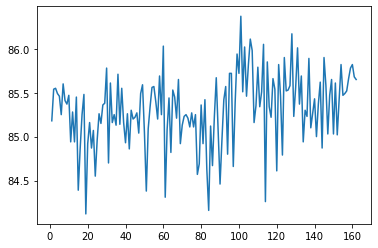

In [13]:
print("Model of: "+model_name +
      " running on: "+dataset_name+"\n")

print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {}%\t||test {}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {}%\t||test {}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [14]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()
# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)